# Data Analysis Phase
In this first notebook I'm running the data analysis phase for the Kaggle's <a href="https://www.kaggle.com/datasets/nancyalaswad90/diamonds-prices" target="_blank">diamonds price dataset</a>. This is a regression problem.

**Author**: Arthur G.

## Loading Dependencies
Here I'm loading and setting up the dependencies for this notebook.

In [1]:
# libs
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox, yeojohnson

# settings
seed = np.random.seed(42)
plt.style.use("ggplot")

## Helper Functions
A set of helper functions to automate data processing.

In [2]:
def plot_grouped_mean_hbar(
    data: pd.DataFrame, var_1: str, var_2: str, 
    groupby: str, plot_labels: tuple, plot_title: str
) -> None:
    """
    This function plots a grouped mean horizontal bar chart.
    """
    _ = data[[var_1, var_2]].groupby([groupby]).mean().sort_values(var_2).plot.barh(figsize=(14, 6))
    plt.legend([])
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.title(plot_title)
    plt.show()
    

def calc_trid_heatmap(data: pd.DataFrame) -> None:
    """
    Calculates a heatmap of correlations between predictors and the target.
    """
    corr = data.corr().round(2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(9, 7))
        ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

## Loading Dataset
Here I'm loading the dataset for initial processing.

In [3]:
data = pd.read_csv(os.path.join("..", "data", "processed", "processed_data.csv"))
data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Data Analysis
Now I'll be analyzing the processed diamonds dataset to better understand the data and to figure out which steps should comprise our pipeline.

### Analyzing Ordered Columns

#### Ordere Column: Cut
The dataset description on Keggle doesn't help us to understand the order of the *cut*, *color* and *clarity* columns, we just know, for sure, that these columns are ordered categorical variables. **We can try to figure out their order by analyzing their corresponding mean price**.

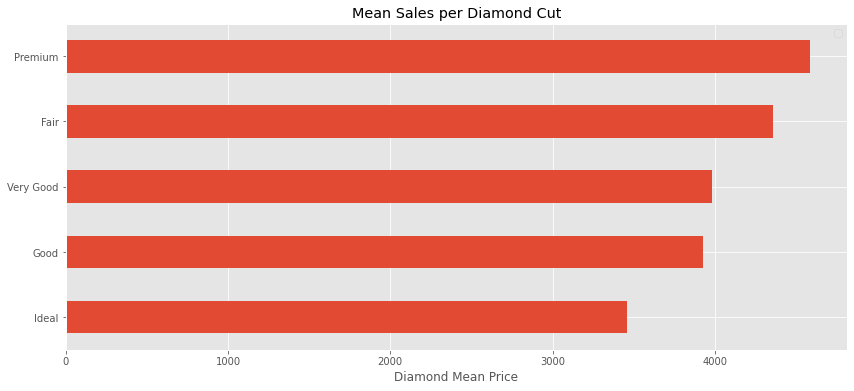

In [4]:
plot_grouped_mean_hbar(
    data=data, 
    var_1="cut", 
    var_2="price", 
    groupby="cut", 
    plot_labels=("Diamond Mean Price", ""), 
    plot_title="Mean Sales per Diamond Cut"
)

It seems that trying to estimate the order of the cut column by the mean sales price makes no sense. This is happening probably due to the influence of variables like **x**, **y** and **z**, which determines the size of the diamond.

For the sake of the experimentation, I'll assume the following order for the cut column:
+ 1. Fair
+ 2. Good
+ 3. Very Good
+ 4. Ideal
+ 5. Premium

This order will be used to determine how our machine learning pipeline will handle this variable in production.

#### Ordered Column: Color
Here I'll be running the same analysis as above but for the color column.

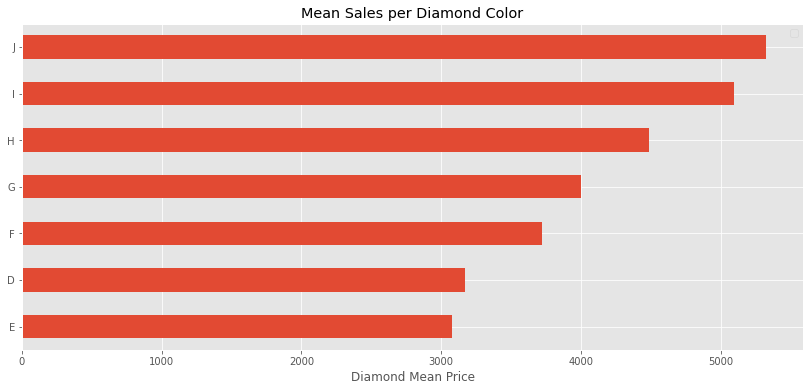

In [5]:
plot_grouped_mean_hbar(
    data=data, 
    var_1="color", 
    var_2="price", 
    groupby="color", 
    plot_labels=("Diamond Mean Price", ""), 
    plot_title="Mean Sales per Diamond Color"
)

#### Ordered Column: Clarity
Here I'll be running the same analysis as above but for the clarity column.

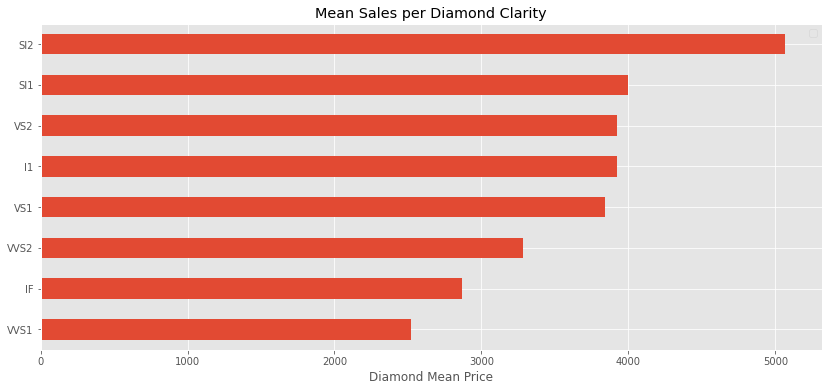

In [6]:
plot_grouped_mean_hbar(
    data=data, 
    var_1="clarity", 
    var_2="price", 
    groupby="clarity", 
    plot_labels=("Diamond Mean Price", ""), 
    plot_title="Mean Sales per Diamond Clarity"
)

The Kaggle's dataset page doesn't give us any information about Color and Clarity orders, and for us it is too much harder to guess the order of these two columns than it is to guess the Cut column, so I'll handle them simply as one-hot encoded categorical columns.

### Analyzing Correlations
Now it's time to calculate the correlation between the numerical predictors with the target column, which is price.

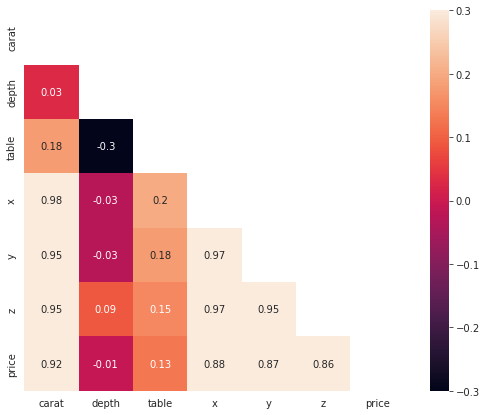

In [7]:
data = data[["carat", "cut", "color", "clarity", "depth", "table", "x", "y", "z", "price"]]
calc_trid_heatmap(data=data.drop(columns=["cut", "color", "clarity"]))

We can cearly see that the variables **carat**, **x**, **y** and **z** are the ones most positively correlated with the target variable, whereas depth and table are significantly weakly correlated.

### Analyzing Target Distribution
In this last step I'm analyzing the raw distribution of the target variable in comparison with it's boxcox and yeo-johnson transformed versions.

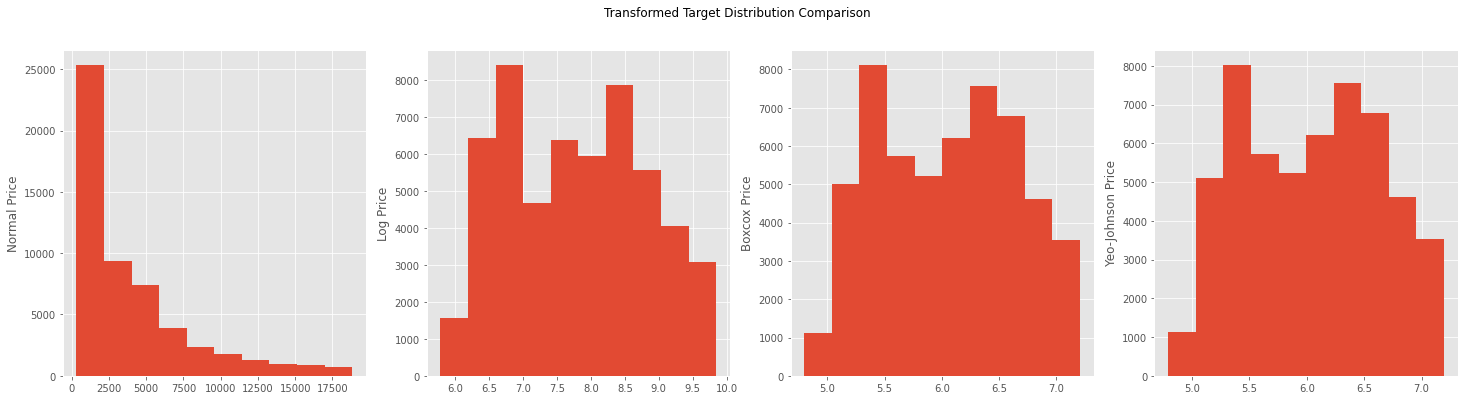

In [8]:
# setting up figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, sharex=False, figsize=(25, 6))
fig.suptitle("Transformed Target Distribution Comparison")

# setting up axis
ax1.hist(data.price.values)
ax1.set_ylabel("Normal Price")
ax2.hist(np.log(data.price.values))
ax2.set_ylabel("Log Price")
ax3.hist(boxcox(data.price.values)[0])
ax3.set_ylabel("Boxcox Price")
ax4.hist(yeojohnson(data.price.values)[0])
ax4.set_ylabel("Yeo-Johnson Price")

plt.show()

It's clear that the raw target variable needs to be transformed due to the significant skew on the data distribution. We can safely use one of the last three transformations shown above. I'll take the Boxcox transformation for no particular reason.